### 步骤：
* 1. 数据可视化，查看违约率，各数据分布，以及有无缺失值
* 2. 分桶，qcut, cut
* 3. 计算WOE,IV，筛选变量
* 4. 利用LR模型进行预测
* 5. 构造评分卡模型进行预测，两个假设一个类比
* 6. 对比总结

In [95]:
# Thinking
# 分桶是不是要train test一起分才可以？
# Yes,不然pcut的时候，test和train的桶就不统一了

In [96]:
import pandas as pd
import numpy as np
import warnings

In [97]:
warnings.filterwarnings('ignore')

In [98]:
train = pd.read_csv('../score_card/cs-training.csv')
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [99]:
test = pd.read_csv('../score_card/cs-test.csv')

In [100]:
#test.head()

In [101]:
# 去除没用的Unnamed
train.drop(columns=train.columns[0], inplace=True)
test.drop(columns=test.columns[0], inplace=True)

#### 标签

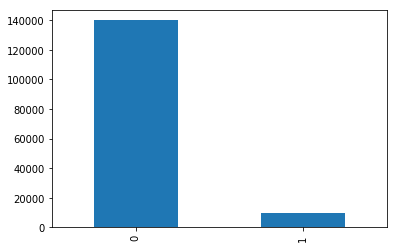

In [102]:
# 查看SeriousDlqin2yrs，违约率
train.SeriousDlqin2yrs.value_counts().plot(kind='bar')

In [103]:
# 违约率
train.SeriousDlqin2yrs.value_counts()[1]/train.SeriousDlqin2yrs.value_counts().sum()

0.06684

In [104]:
odds = train.SeriousDlqin2yrs.value_counts()[1]/train.SeriousDlqin2yrs.value_counts()[0]
odds

0.07162758798062498

#### 缺失值

In [105]:
# MonthlyIncome, NumberOfDependents存在缺失值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [106]:
# test中也一样
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtype

In [107]:
# 查看这两列的情况
train.MonthlyIncome.value_counts()

5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
           ... 
3847.0        1
10113.0       1
14210.0       1
13023.0       1
1037.0        1
Name: MonthlyIncome, Length: 13594, dtype: int64

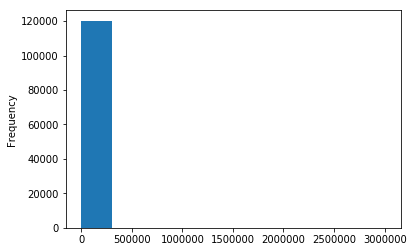

In [108]:
# 大部分人还是低收入，只有极少数高收入人群
train.MonthlyIncome.plot(kind='hist')

In [109]:
# 由于数据分布呈左偏，均值被少部分的高收入人群给拉高，大于中位数，因此这里以中位数填充缺失值
print('均值：', train.MonthlyIncome.mean())
print('中位数：',train.MonthlyIncome.median())

均值： 6670.221237392844
中位数： 5400.0


In [110]:
# 训练集
train.MonthlyIncome.fillna(train.MonthlyIncome.median(), inplace=True)

In [111]:
# 测试集
test.MonthlyIncome.fillna(train.MonthlyIncome.median(), inplace=True)

In [112]:
train.MonthlyIncome.isna().sum()

0

###### 对于NumberOfDependents，家庭受养人数

In [113]:
train.NumberOfDependents.value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

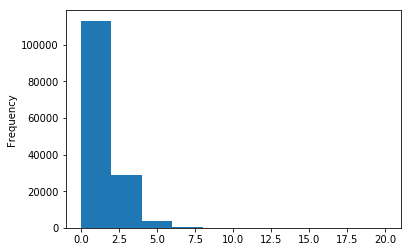

In [114]:
train.NumberOfDependents.plot(kind='hist')

In [115]:
# 大部分还是自己生活呢
print('均值：', train.NumberOfDependents.mean())
print('中位数：',train.NumberOfDependents.median())

均值： 0.7572222678605657
中位数： 0.0


In [116]:
# 训练集
train.NumberOfDependents.fillna(train.MonthlyIncome.median(), inplace=True)

In [117]:
# 测试集
test.NumberOfDependents.fillna(train.MonthlyIncome.median(), inplace=True)

In [118]:
train.MonthlyIncome.isna().sum()

0

#### 变量分桶
* age [-math.inf, 25, 40, 50, 60, 70, math.inf]
* NumberOfDependents 家属人数 [-math.inf,2,4,6,8,10,math.inf]
* NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate三种逾期</b>
 [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
* 其余字段 RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分五段 qcut(data, q=5)

In [119]:
import math

In [120]:
split_point = train.shape[0]
whole_data = train.append(test)

In [121]:
whole_data['age'] = pd.cut(whole_data.age, [-math.inf, 25, 40, 50, 60, 70, math.inf])
whole_data['NumberOfDependents'] = pd.cut(whole_data.NumberOfDependents, [-math.inf,2,4,6,8,10,math.inf])

whole_data['NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(whole_data['NumberOfTime30-59DaysPastDueNotWorse'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])
whole_data['NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(whole_data['NumberOfTime60-89DaysPastDueNotWorse'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])
whole_data['NumberOfTimes90DaysLate'] = pd.cut(whole_data['NumberOfTimes90DaysLate'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])

whole_data.RevolvingUtilizationOfUnsecuredLines = pd.qcut(whole_data.RevolvingUtilizationOfUnsecuredLines , q=5, duplicates='drop')
whole_data.DebtRatio = pd.qcut(whole_data.DebtRatio , q=5, duplicates='drop')
whole_data.MonthlyIncome = pd.qcut(whole_data.MonthlyIncome , q=5, duplicates='drop')
whole_data.NumberOfOpenCreditLinesAndLoans = pd.qcut(whole_data.NumberOfOpenCreditLinesAndLoans , q=5, duplicates='drop')
whole_data.NumberRealEstateLoansOrLines = pd.qcut(whole_data.NumberRealEstateLoansOrLines , q=5, duplicates='drop')

In [122]:
# 学这个startswith的用法
# # 统计分箱字段，以bin_开头
# bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
# bin_cols

##### pd.qcut 得注意一个参数duplicates='drop'，
* 因为有时候用频次来划分边界是会造成两个桶存在同一个取值，比如1000个数中0占了900个，1占100个，如果按q=2,分两个桶，则会500个0为桶1，400个1和100个0为桶2，这就会造成混乱，数值1到底是哪个桶？因此我们将其进行合并。。。
* 但合并也有不合理得地方，那就按规则来分吧

##### 那train和test是不是要合并后再分桶呢？
##### 按规则分的可以不用，但按频率分应该要合并后再分桶

In [123]:
train = whole_data.iloc[:split_point,:]
test = whole_data.iloc[split_point:,:]

#### 计算每个特征的WOE，IV

In [124]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,"(0.702, 50708.0]","(40.0, 50.0]","(1.0, 2.0]","(0.466, 3.908]","(8233.0, 7727000.0]","(12.0, 85.0]","(-inf, 1.0]","(2.0, 54.0]","(-inf, 1.0]","(-inf, 2.0]"
1,0.0,"(0.702, 50708.0]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
2,0.0,"(0.271, 0.702]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
3,0.0,"(0.083, 0.271]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(4.0, 6.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
4,0.0,"(0.702, 50708.0]","(40.0, 50.0]","(-inf, 1.0]","(-0.001, 0.133]","(8233.0, 7727000.0]","(6.0, 9.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"


In [125]:
# 放一个临时值，计算各特征各标签的数量
train['count'] = 1

In [126]:
train.columns.tolist()[1:-1]

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [132]:
%%time
# 遍历每一个feature(除了第一个label,和最后一个count)
for col in train.columns.tolist()[1:-1]:
    
    feat = train.groupby([col, 'SeriousDlqin2yrs'], as_index=False)['count'].count()
    # 每个桶的总数
    sum = feat.groupby(col, as_index=False)['count'].sum()

    # 坏样本数
    bad = feat[feat.SeriousDlqin2yrs==1][sum.columns]
    bad['count']= bad['count'].apply(lambda x: 0 if str(x)=='nan' else x)
    bad.rename(columns={'count':'bad'}, inplace=True)

    # 好样本数
    good = feat[feat.SeriousDlqin2yrs==0][sum.columns]
    good['count']= good['count'].apply(lambda x: 0 if str(x)=='nan' else x)
    good.rename(columns={'count':'good'}, inplace=True)

    WOE = sum.merge(good, on=col).merge(bad, on=col)

    # 该桶好/坏的占比
    WOE['good_rate'] = WOE['good']/WOE['count']
    WOE['bad_rate'] = WOE['bad']/WOE['count']

    # 好/坏占总的好/坏的比例
    WOE['margin_good_rate'] = WOE.good/WOE.good.sum()
    WOE['margin_bad_rate'] = WOE.bad/WOE.bad.sum()
    
    # 其中NumberOfTime60-89DaysPastDueNotWorse存在bad为0的情况，因此需要用log1p避免结果为inf
    WOE['WOE'] = np.log1p(WOE['margin_bad_rate']/WOE['margin_good_rate'])

    # WOE 只考虑的乘除，嘿嘿，不够全面，来个加减吧
    WOE['IV'] = (WOE['margin_bad_rate']-WOE['margin_good_rate']) * WOE['WOE']
    WOE = WOE[[col, 'WOE', 'IV']]

    # 每一列的总和，最主要是IV值
    WOE.loc['sum'] = ['sum'] + WOE.sum(axis=0).values.tolist()

    # 判断IV值是否小于0.1, 如果小于0.1则跳过
    IV = WOE.IV['sum']
    print('\n{}的IV值为：{}'.format(col, IV))
    if IV<0.1:
        print('Dropt...')
        train.drop(columns=col, inplace=True)
        test.drop(columns=col, inplace=True)
        continue
    print('Saved...')
        
    # 桶和WOE的对应关系
    transform_list = WOE.set_index(col)['WOE'] #, inplace=True)
    # 将RevolvingUtilizationOfUnsecuredLines转换成WOE编码
    train.loc[:,col]= train.loc[:,col].apply(lambda x: transform_list.loc[x])
    
    # 测试集
    test.loc[:,col]= test.loc[:,col].apply(lambda x: transform_list.loc[x])


RevolvingUtilizationOfUnsecuredLines的IV值为：0.5270952658076192

age的IV值为：0.10630739209281985

NumberOfTime30-59DaysPastDueNotWorse的IV值为：0.3406105523141427

DebtRatio的IV值为：0.03194889657494044
特征DebtRatio的IV小于0.1，droping...

MonthlyIncome的IV值为：0.028130802154365364
特征MonthlyIncome的IV小于0.1，droping...

NumberOfOpenCreditLinesAndLoans的IV值为：0.02500753746836124
特征NumberOfOpenCreditLinesAndLoans的IV小于0.1，droping...

NumberOfTimes90DaysLate的IV值为：0.37470365850920745

NumberRealEstateLoansOrLines的IV值为：0.006035388120960453
特征NumberRealEstateLoansOrLines的IV小于0.1，droping...

NumberOfTime60-89DaysPastDueNotWorse的IV值为：0.20329806205744644

NumberOfDependents的IV值为：0.009196548559156475
特征NumberOfDependents的IV小于0.1，droping...
Wall time: 594 ms


In [133]:
train.drop(columns='count', inplace=True)

In [134]:
train.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
dtype: int64

#### 切分验证集

In [135]:
y_train = train.SeriousDlqin2yrs.values
x_train = train.drop(columns = 'SeriousDlqin2yrs').values

In [136]:
x_test = test.drop(columns = 'SeriousDlqin2yrs').values

#### Thinking: WOE还要不要做归一化呢？ 
* A: 结果差不多

In [137]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# x_train_ss = ss.fit_transform(x_train)
# x_test_ss = ss.transform(x_test)

# from sklearn.model_selection import train_test_split
#x_train_ss, x_val_ss, y_train, y_val = train_test_split(x_train_ss, y_train, test_size=0.2, random_state=33)

In [138]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=33)

In [139]:
# 利用LR模型预测 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
lr = LogisticRegression(random_state=33)

In [140]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=33, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [141]:
y_pred = lr.predict(x_val)
print('ACC:', accuracy_score(y_pred, y_val))
print('ROC:', roc_auc_score(y_pred, y_val))

ACC: 0.9364333333333333
ROC: 0.7787691092695656


* 本项目主要利用WOE和IV来衡量特征变量的预测能力，或者说特征变量的特征区分度。并对原特征进行WOE编码，代替原特征输入模型，再者，剔除IV<0.1的特征，避免数据冗余。通过实验可以得出只利用筛选后的特征比无脑地将全量特征喂给模型更有效。

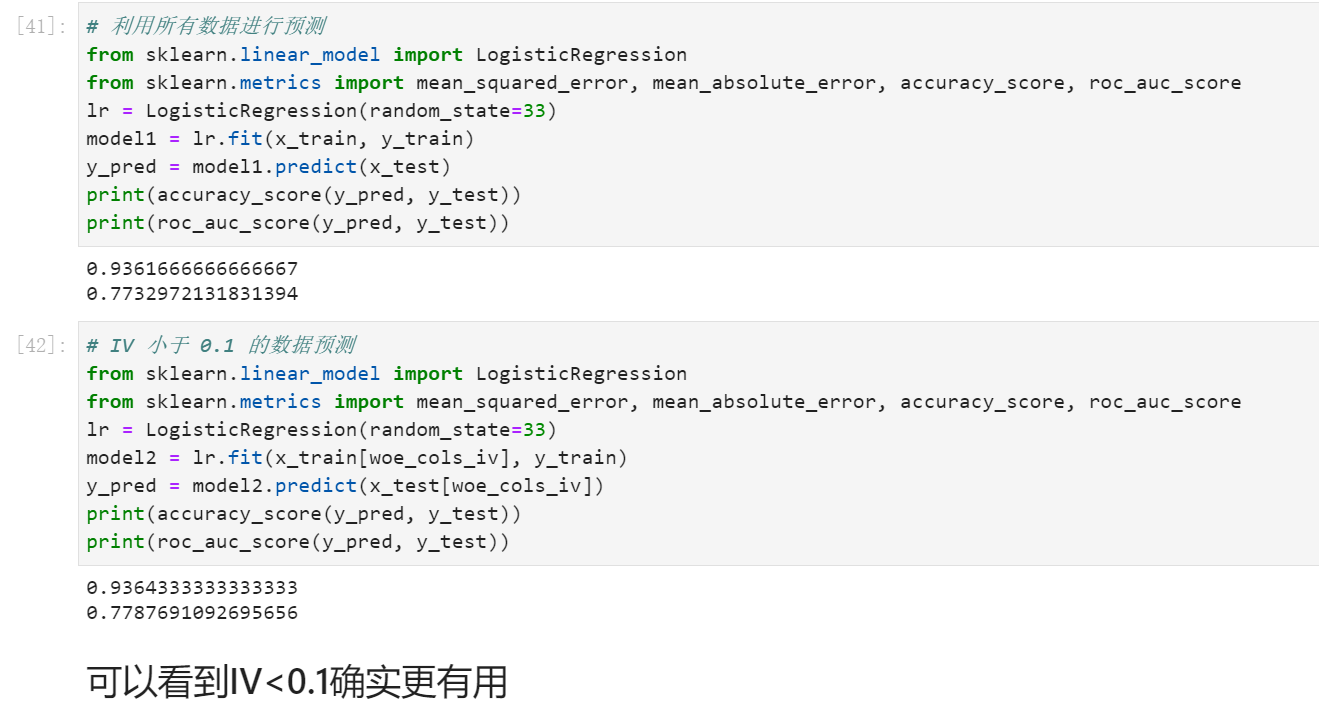

##### Thinking :
* WOE依赖于对原始特征的分箱操作，这个分箱并没有明确的理论指导，更多的是对业务的理解，譬如，年龄多大是青年、中年、老年，不同时代，人的寿命长短不一，划分的界限也不一样，因此，分箱是一个不太可控的因素。由于分箱的不准确，或者偏差较大，边界问题等，可能会导致IV值<0.1，最终导致该变量被丢弃。因此应该多尝试，多理解业务场景，这样更有利于我们对边界的定义。